# Homework 3

... or whatever other problems I feel like working on

In [86]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite, EstimatedPdf, MakeBinomialPmf, Beta

import thinkplot

import numpy as np
import pandas as pd

# The flea beetle problem

Different species of flea beetle can be distinguished by the width and angle of the aedeagus. The data below includes measurements and know species classification for 74 specimens.

Suppose you discover a new specimen under conditions where it is equally likely to be any of the three species. You measure the aedeagus and width 140 microns and angle 15 (in multiples of 7.5 degrees). What is the probability that it belongs to each species?

In [2]:
df = pd.read_csv('../data/flea_beetles.csv', delimiter='\t');

In [18]:
beetle_widths = {species: EstimatedPdf(list(df.Width[df.Species == species])) for species in df.Species.unique()}
beetle_angles = {species: EstimatedPdf(list(df.Angle[df.Species == species])) for species in df.Species.unique()};

In [30]:
dist = beetle_angles['Con']

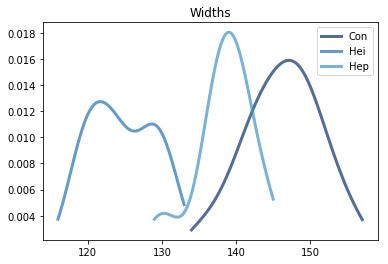

In [46]:
for species, dist in beetle_widths.items():
    thinkplot.Plot(dist.MakePmf(), label=species)
thinkplot.Config(title='Widths')

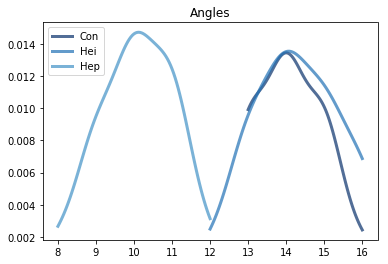

In [45]:
for species, dist in beetle_angles.items():
    thinkplot.Plot(dist.MakePmf(), label=species)
thinkplot.Config(title='Angles')

In [47]:
class Beetles(Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: tuple of (width, angle)
        hypo: Beetle species (string)
        """
        species = hypo
        width, angle = data
        return float(beetle_widths[species].Density(width) * beetle_angles[species].Density(angle))

No handles with labels found to put in legend.


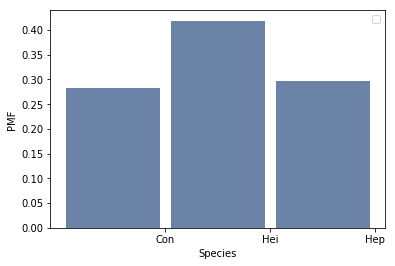

In [48]:
prior = Beetles(df.Species)
thinkplot.Hist(prior)
thinkplot.Config(xlabel='Species', ylabel='PMF')

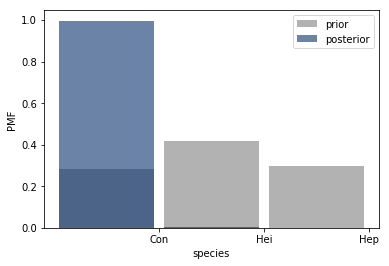

In [49]:
posterior = prior.Copy()
posterior.Update((140, 15))
thinkplot.Hist(prior, color='gray', label='prior')
thinkplot.Hist(posterior, label='posterior')
thinkplot.Config(xlabel='species', ylabel='PMF')

# Game of Ur
In the Royal Game of Ur, players advance tokens along a track with 14 spaces.  To determine how many spaces to advance, a player rolls 4 dice with 4 sides.  Two corners on each die are marked; the other two are not.  The total number of marked corners -- which is 0, 1, 2, 3, or 4 -- is the number of spaces to advance.

For example, if the total on your first roll is 2, you could advance a token to space 2.  If you roll a 3 on the next roll, you could advance the same token to space 5.

Suppose you have a token on space 13.  How many rolls did it take to get there?

In [53]:
ur_roll = MakeBinomialPmf(n=4, p=0.5);

In [83]:
class Ur(Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: Which space the token is on
        hypo: Number of rolls taken
        """
        rolls = hypo
        space = data
        
        # TODO(eric): Use a single binomial distribution for speed
        return sum([ur_roll]*rolls).Prob(space)

In [116]:
# Flat prior
prior = Ur(range(1,20));

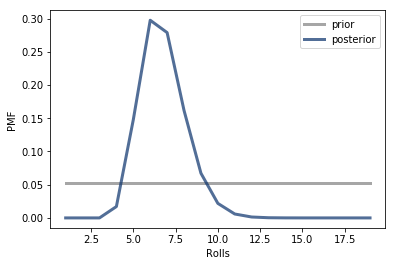

In [117]:
posterior = prior.Copy()
posterior.Update(13)

thinkplot.Plot(prior, color='gray', label='prior')
thinkplot.Plot(posterior, label='posterior')
thinkplot.Config(xlabel='Rolls', ylabel='PMF')

# The alien blaster problem

In preparation for an alien invasion, the Earth Defense League (EDL) has been working on new missiles to shoot down space invaders.  Of course, some missile designs are better than others; let's assume that each design has some probability of hitting an alien ship, x.

Based on previous tests, the distribution of x in the population of designs is well described by a Beta distribution with parameters 5, 10.

Now suppose the new ultra-secret Alien Blaster 9000 is being tested.  In a press conference, an EDL general reports that the new design has been tested twice, taking two shots during each test.  The results of the test are confidential, so the general won't say how many targets were hit, but they report: "The same number of targets were hit in the two tests, so we have reason to think this new design is consistent."

Is this data good or bad; that is, does it increase or decrease your estimate of x for the Alien Blaster 9000?

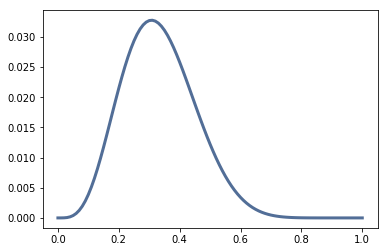

In [92]:
prior = Beta(5, 10)
thinkplot.Pdf(prior.MakePmf())

In [94]:
class Blaster(Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: tuple of (number of tests, shots per test)
        hypo: hit probability of blaster
        """
        n_tests, shots_per = data
        
        hits_per_test = MakeBinomialPmf(n_tests, hypo)
        
        likelihood = 0
        for hits, p in hits_per_test.Items():
            likelihood += p ** n_tests
        
        return likelihood

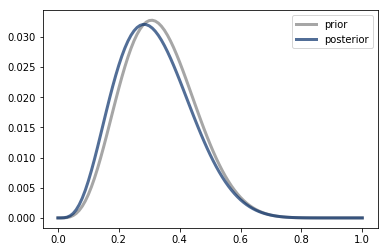

In [105]:
blaster = Blaster(prior.MakePmf())
blaster.Update((2,2))

thinkplot.Pdf(prior.MakePmf(), color='grey', label='prior')
thinkplot.Pdf(blaster, label='posterior')
thinkplot.Config()

# The grizzly bear problem

In 1996 and 1997 Mowat and Strobeck deployed bear traps in locations in British Columbia and Alberta, in an effort to estimate the population of grizzly bears.  They describe the experiment in "Estimating Population Size of Grizzly Bears Using Hair Capture, DNA Profiling, and Mark-Recapture Analysis"

The "trap" consists of  a lure and several strands of barbed wire intended to capture samples of hair from bears that visit the lure.  Using the hair samples, the researchers use DNA analysis to identify individual bears.

During the first session, on June 29, 1996, the researchers deployed traps at 76 sites.  Returning 10 days later, they obtained 1043 hair samples and identified 23 different bears.  During a second 10-day session they obtained 1191 samples from 19 different bears, where 4 of the 19 were from bears they had identified in the first batch.

To estimate the population of bears from this data, we need a model for the probability that each bear will be observed during each session.  As a starting place, we'll make the simplest assumption, that every bear in the population has the same (unknown) probability of being sampled during each round.

We also need a prior distribution for the population.  As a starting place, let's suppose that, prior to this study, an expert in this domain would have estimated that the population is between 100 and 500, and equally likely to be any value in that range.

In [111]:
from scipy.special import factorial

class BearPop(Suite):
    
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        
        data: tuple of (num_first_session, num_second_session, overlap)
        hypo: size of bear population
        """
        pop = hypo
        num_first_session, num_second_session, overlap = data
        
        p_returner = num_first_session / pop
        p_new = 1 - p_returner
        
        return (
            p_returner ** overlap * 
            p_new ** (num_second_session - overlap) *
            (factorial(num_second_session) / (factorial(overlap)*factorial(num_second_session-overlap)))
        )

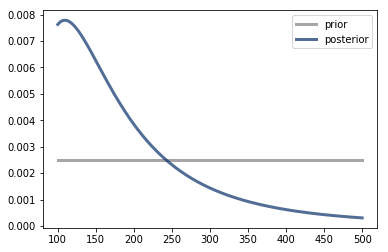

In [115]:
prior = BearPop(range(100,501))
posterior = prior.Copy()
posterior.Update((23, 19, 4))

thinkplot.Pdf(prior, color='grey', label='prior')
thinkplot.Pdf(posterior, label='posterior')
thinkplot.Config()